## Import the CSV Data

In [1]:
import pandas as pd
import glob

# Define the range of legislative sessions
sessions = range(123, 126)  # 118 to 125 inclusive

# Create a list to store DataFrames
df_list = []

# Load each CSV and append to the list
for session in sessions:
    file_path = f"../data/bills/{session}th_assembly_bills.csv"
    df = pd.read_csv(file_path)
    df_list.append(df)

# Concatenate all DataFrames into a single one
df_legislation = pd.concat(df_list, ignore_index=True)

# Keep only relevant columns and create context
df_Bill = df_legislation[["bill_id", "title", "description"]].copy()
df_Bill["context"] = df_Bill["title"] + " " + df_Bill["description"]

# # Save to a single CSV (optional)
# df_Bill.to_csv("../data/all_sessions_bills.csv", index=False)

## Downloading Documents

In [2]:
import requests 
import os
import json
import re
from weasyprint import HTML
from base64 import b64decode

# Insert LegiScan API key here
apiKey = ""
urls = {}

# Create a dictionary with bill ids and their api urls
for index, row in df_Bill.iterrows():
    urls[row["bill_id"]] = f"https://api.legiscan.com/?key={apiKey}&op=getBill&id={row["bill_id"]}"

# Set up the path for the pdfs
savePath = "../data/billDocs"
os.makedirs(savePath, exist_ok=True)
pdfs = []
count = 0


maxDocs = 2500
progressThresh = 100

# Request and convert full text data to pdfs
for billID, url in urls.items():
    if count < maxDocs:
        count += 1
        if f"{billID}.pdf" in os.listdir(savePath):
            if count % progressThresh == 0:
                print(f"{billID}.pdf already exists ({count}/{maxDocs})")
            pdfPath = os.path.join(savePath, f"{billID}.pdf")
            pdfs.append(pdfPath)
        else:
            try:
                # Request bill information
                response = requests.get(url)
                if response.json()["bill"]["texts"]:
                    # Get the most recent document id
                    docID = response.json()["bill"]["texts"][0]["doc_id"]
            
                    # Request the document text
                    urls[billID] = f"https://api.legiscan.com/?key={apiKey}&op=getBillText&id={docID}"
                    response = requests.get(urls[billID])
            
                    # Decode and convert the html text to a pdf format
                    pdfPath = os.path.join(savePath, f"{billID}.pdf")
                    billText = str(b64decode(response.json()["text"]["doc"], validate=True))
                    pdfText = HTML(string=billText).write_pdf()
            
                    # Save the text data to a pdf 
                    with open(pdfPath, "wb") as file:
                        file.write(pdfText)
                        pdfs.append(pdfPath)
                        if count % progressThresh == 0:
                            print(f"Successfully downloaded {billID}.pdf ({count}/{maxDocs})")
                        file.close()
            except Exception as e:
                print(e)
                count -= 1

print("All documents downloaded")

1134428.pdf already exists (100/2500)
1134672.pdf already exists (200/2500)
1134325.pdf already exists (300/2500)
1141619.pdf already exists (400/2500)
1165654.pdf already exists (500/2500)
1194436.pdf already exists (600/2500)
Expecting value: line 1 column 1 (char 0)
1233279.pdf already exists (700/2500)
1249033.pdf already exists (800/2500)
1284938.pdf already exists (900/2500)
1288510.pdf already exists (1000/2500)
Expecting value: line 1 column 1 (char 0)
1337917.pdf already exists (1100/2500)
1153730.pdf already exists (1200/2500)
1170761.pdf already exists (1300/2500)
1194490.pdf already exists (1400/2500)
1233580.pdf already exists (1500/2500)
1251389.pdf already exists (1600/2500)
1257917.pdf already exists (1700/2500)
1309058.pdf already exists (1800/2500)
1323844.pdf already exists (1900/2500)
1337825.pdf already exists (2000/2500)
1356094.pdf already exists (2100/2500)
1365521.pdf already exists (2200/2500)
1378792.pdf already exists (2300/2500)
1250574.pdf already exists (

## Convert PDFs to Images 

0/2500
1000/2500
2000/2500


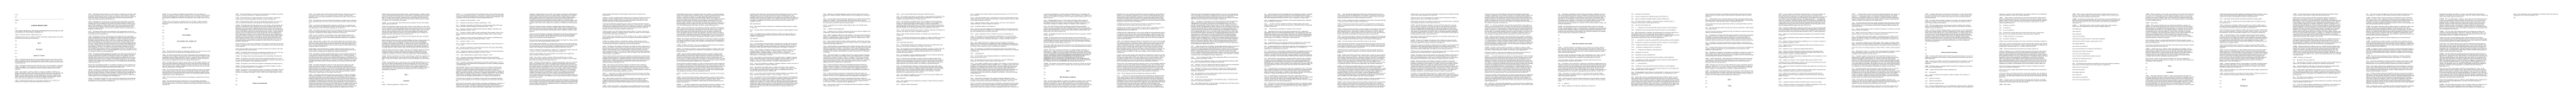

In [3]:
import matplotlib.pyplot as plt
import fitz

images = {}
testBillIndex = 0

# Save a dictionary of images of the pdf pages
pdfs.sort()
for i in range(len(pdfs)):
    if i % 1000 == 0:
        print(f"{i}/{len(pdfs)}")
    doc = fitz.open(pdfs[i])
    images[i] = []
    for page in doc:
        pixmap = page.get_pixmap()
        images[i].append(pixmap.pil_image())
    doc.close()

# Plot the given test bill's images 
fig, axes = plt.subplots(1, len(images[testBillIndex]), figsize=(30, 30))

if len(images[testBillIndex]) > 1:
    for i, ax in enumerate(axes.flat):
        img = images[testBillIndex][i]
        ax.imshow(img)
        ax.axis("off")
else:
    img = images[testBillIndex][0]
    axes.imshow(img)
    axes.axis("off")

plt.tight_layout()
plt.show()

## Implement ColPali using Byaldi

2500
2500
Verbosity is set to 1 (active). Pass verbose=0 to make quieter.


`config.hidden_act` is ignored, you should use `config.hidden_activation` instead.
Gemma's activation function will be set to `gelu_pytorch_tanh`. Please, use
`config.hidden_activation` if you want to override this behaviour.
See https://github.com/huggingface/transformers/pull/29402 for more details.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

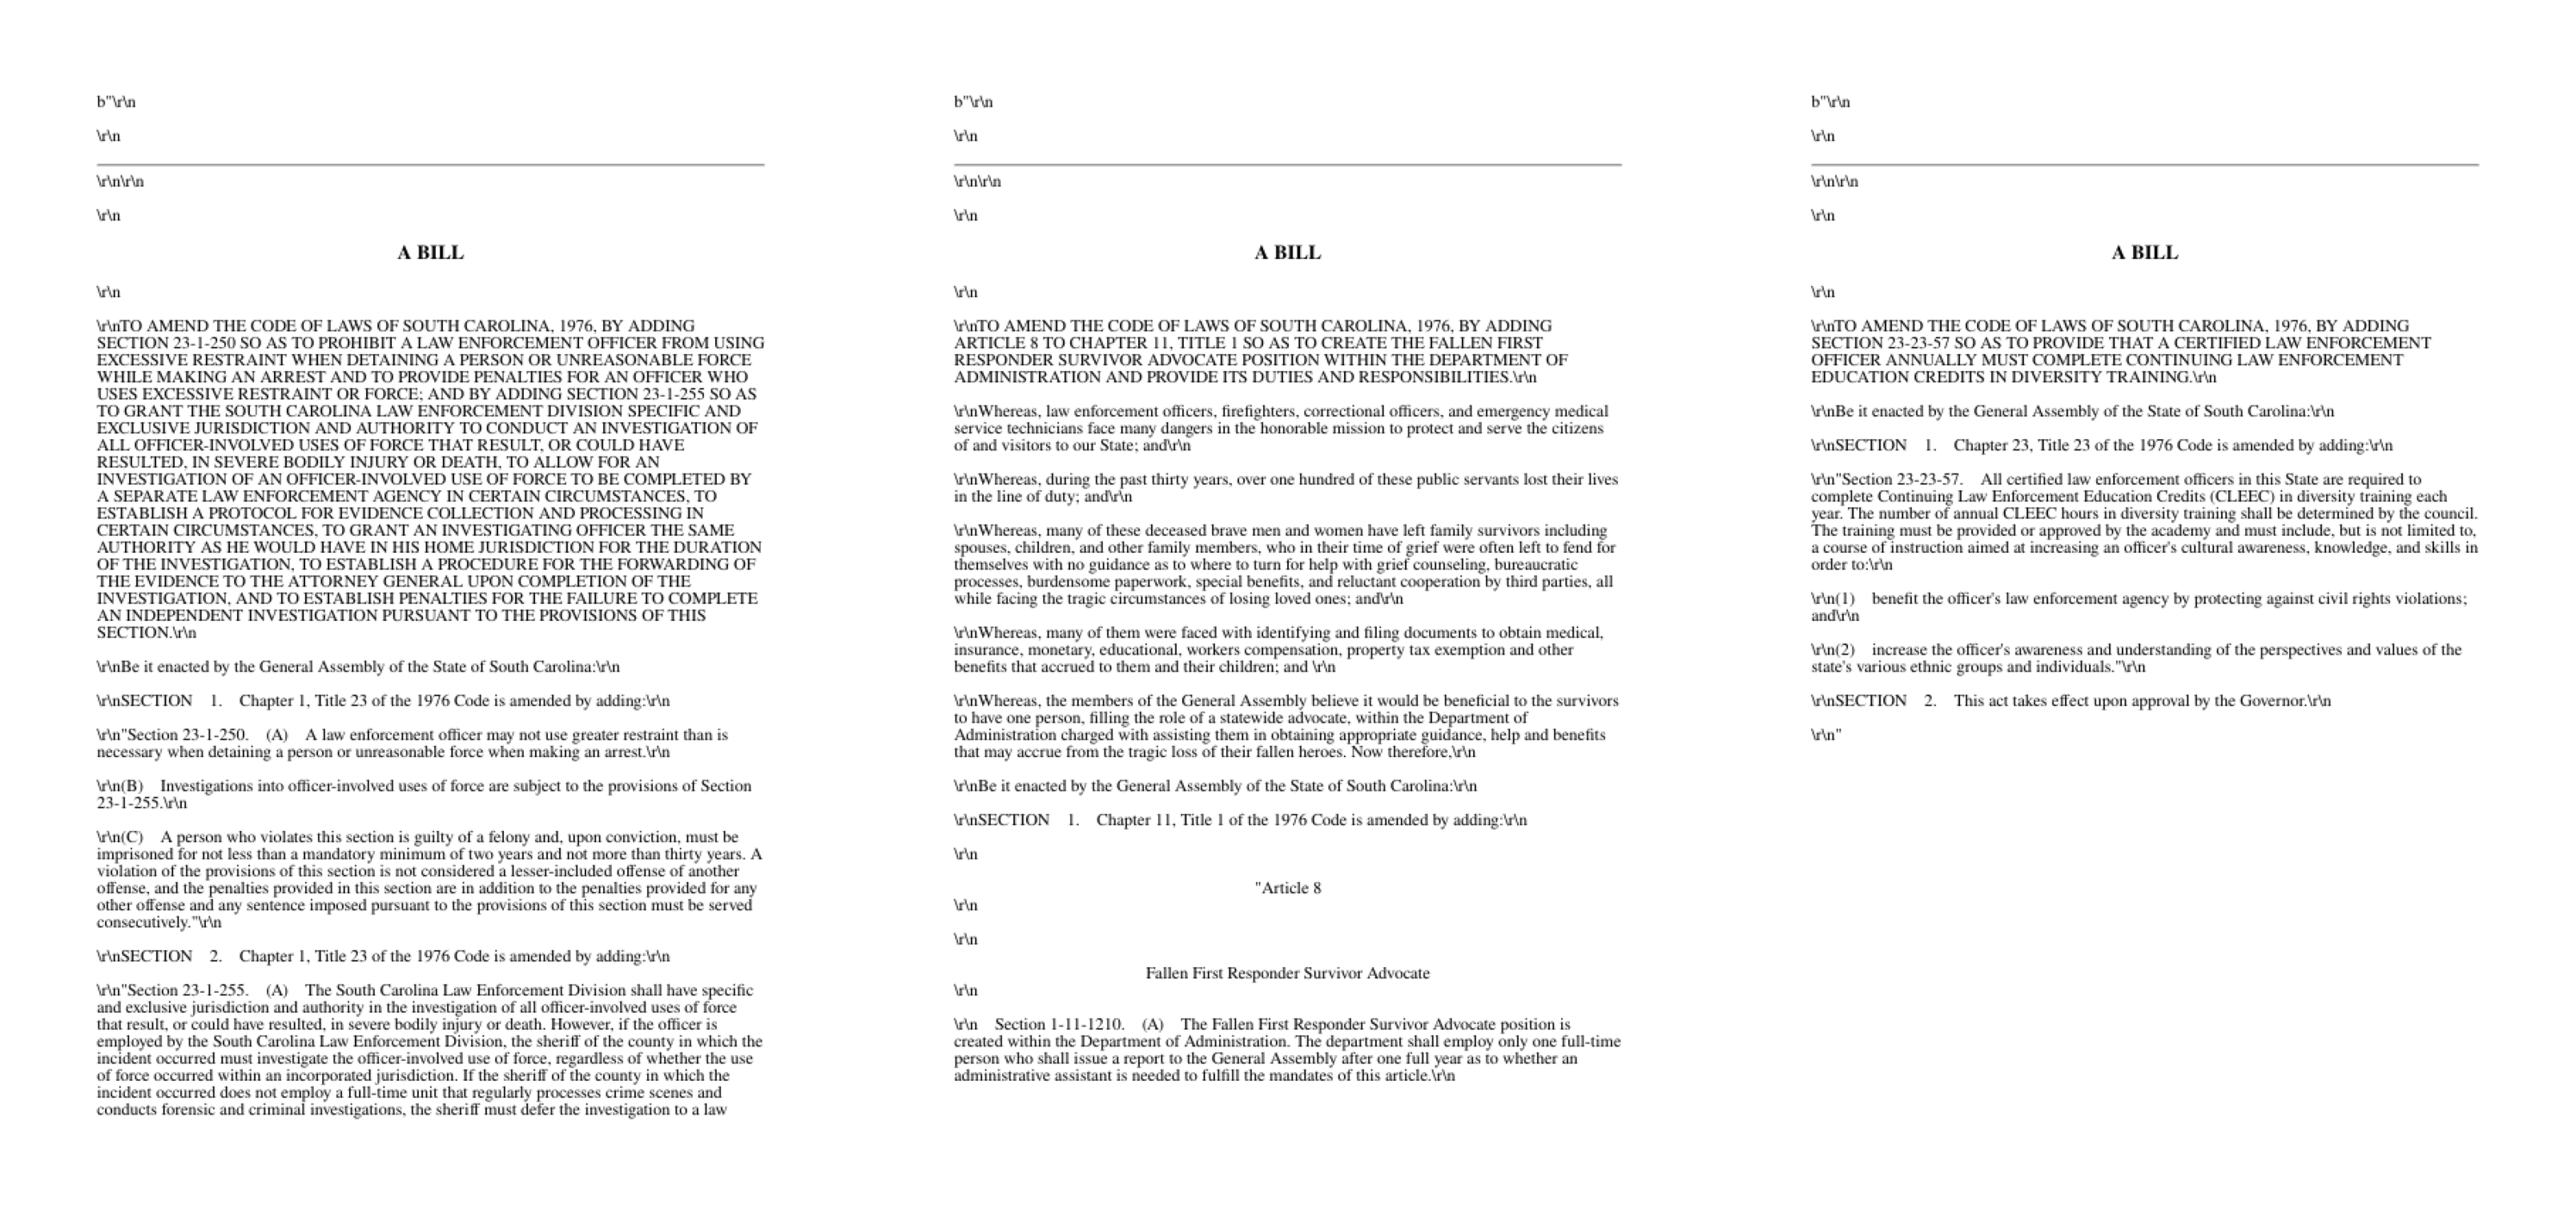

In [4]:
from byaldi import RAGMultiModalModel

# Clears the data directory of potentially generated non-pdfs
def cleanDirectory(directory):
    for filename in os.listdir(directory):
        filepath = os.path.join(directory, filename)
        
        if os.path.isfile(filepath) and (not filepath in pdfs):
            os.remove(filepath)
            print(f"Deleted: {filepath}")
        elif os.path.isdir(filepath):
            cleanDirectory(filepath)
            os.rmdir(filepath)
            print(f"Deleted: {filepath}")

cleanDirectory(savePath)

# Load and initialize ColPali
try:
    colpali = RAGMultiModalModel.from_index(index_path="images_index")
except Exception as e:
    print(e)
    colpali = RAGMultiModalModel.from_pretrained("vidore/colpali-v1.2")
    colpali.index(input_path=savePath, index_name="images_index", overwrite=True)

# Function to retrieve the documents with RAG
def retrieveDocuments(searchText, numDocs, docImages):
    relevantDocs = colpali.search(searchText, k=numDocs)
    relevantImages = []
    
    for doc in relevantDocs:
        id = doc["doc_id"]
        pageNum = doc["page_num"] - 1
        relevantImages.append(docImages[id][pageNum])

    return relevantImages

# Test the document retrieval system
relevantImages = retrieveDocuments("Bills related to law enforcement", 3, images)

# Plot the given test bill's images 
fig, axes = plt.subplots(1, 3, figsize=(30, 30))

for i, ax in enumerate(axes.flat):
    img = relevantImages[i]
    ax.imshow(img)
    ax.axis("off")

plt.tight_layout()
plt.show()

## Adding the VLM

In [8]:
from transformers import Qwen2VLForConditionalGeneration, Qwen2VLProcessor
from qwen_vl_utils import process_vision_info
import torch

def answerWithColpali(prompt, docImages, numDocs=3, additionalArgs=None):
    systemPrompt = """You are a chatbot meant to help average citizens understand their local government by informing them about various legal bills that you have been supplied with. When answering prompts,
    please inform the user of the specific bills that are being referenced. Answer the following prompt as concisly as possible in a way that is easy for an average citizen to understand: """
    
    
    vlm = Qwen2VLForConditionalGeneration.from_pretrained(
        "Qwen/Qwen2-VL-7B-Instruct",
        torch_dtype=torch.bfloat16
    ).cuda()

    vlmProcessor = Qwen2VLProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")
    relevantImages = retrieveDocuments(prompt, numDocs, docImages)

    template = [
        {
            "role": "user",
            "content": [{"type": "image", "image": image} for image in relevantImages]
            + [{"type": "text", "text": systemPrompt + prompt}],
        }
    ]

    vlmText = vlmProcessor.apply_chat_template(template, tokenize=False, add_generation_prompt=True)
    inputs = vlmProcessor(
        text=[vlmText],
        images=relevantImages,
        padding=True,
        return_tensors="pt"
    ).to("cuda")
    
    if additionalArgs == None:
        additionalArgs = {
        "max_new_tokens": 512,
        "temperature": 0.7,       
        "top_p": 0.9,         
        "do_sample": True,       
        }
    
    with torch.no_grad():
        generatedIds = vlm.generate(**inputs, **additionalArgs)
        
    unprocessedResult = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generatedIds)]
    vlmResult = vlmProcessor.batch_decode(unprocessedResult, skip_special_tokens=True, clean_up_tokenization_spaces=False)
    
    return vlmResult

print(answerWithColpali("Can you tell me about recent bills passed relating to law enforcement?", numDocs=3, docImages=images)[0])

Loading checkpoint shards:   0%|          | 0/5 [00:00<?, ?it/s]

Certainly! There have been several recent bills passed relating to law enforcement in South Carolina. One bill amends the Code of Laws of South Carolina, 1976, by adding Article 8 to Chapter 11, Title 1. This bill creates the Fallen First Responder Survivor Advocate position within the Department of Administration and provides its duties and responsibilities. Another bill amends Section 44-23-1150 of the Code of Laws of South Carolina, 1976, relating to sexual misconduct with inmates or offenders. This bill prohibits sexual conduct between law enforcement officers and inmates, patients, and offenders. Additionally, there have been bills relating to the purpose of the Law Enforcement Training Council and the Criminal Justice Academy, and the definition of certain terms.
